In [51]:
# importamos paquetes necesarios
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Taller 2
Por: Paola Andrea Fernández

Escoja una serie del S&P 500 desde Enero 1 de 2022 hasta  Julio 26 de 2022, y realice todo el proceso de Identificación visto en clase

A continuación se encuentra la serie de precios de cierre del S&P500 para el periodo solicitado:

<AxesSubplot:title={'center':'S&P 500'}, xlabel='Date'>

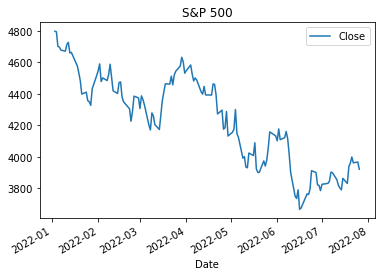

In [2]:
stock = yf.Ticker("^GSPC")
prices = stock.history(start="2022-01-01",  end="2022-07-27")[['Close']]
prices.plot(title = 'S&P 500')

# Identificación

## 1. Evaluar estacionariedad
Dado que la no-estacionariedad de una serie genera problemas en la estimación de los parámetros, debemos de asegurarnos de usar una serie estacionaria. Para esto vamos a utilizar algunas pruebas estadisticas para asegurar la estacionariedad de la serie.

### 1.1 Pruebas de raíces unitarias

Prueba de Dickey-Fuller aumentada

In [3]:
def DF_test(series):
    result = adfuller(series, autolag="AIC")
    stat, p_value, _ ,_ ,crit_values,_ = result
    reject = 'Reject null hypothesis' if p_value < 0.05 else 'Failed to reject null hypothesis'
    conc = 'Time series is non-stationary' if reject == 'Failed to reject null hypothesis' else 'Time series is stationary'
    print("Null hypothesis: Time series is non-stationary \nStatistic: {} \nP-value: {} \n{} \n:: {}".format(stat, p_value, reject, conc))
DF_test(prices)

Null hypothesis: Time series is non-stationary 
Statistic: -1.8242163024089804 
P-value: 0.3685069643701249 
Failed to reject null hypothesis 
:: Time series is non-stationary


Prueba KPSS

In [4]:
def KPSS_test(series):
    result = kpss(series, regression="c", nlags="auto")
    stat, p_value, _  ,crit_values = result
    reject = 'Reject null hypothesis' if p_value < 0.05 else 'Failed to reject null hypothesis'
    conc = 'Time series is stationary' if reject == 'Failed to reject null hypothesis' else 'Time series is non-stationary'
    print("Null hypothesis: Time series is stationary \nStatistic: {} \nP-value: {} \n{} \n:: {}".format(stat, p_value, reject, conc))
KPSS_test(prices)

Null hypothesis: Time series is stationary 
Statistic: 1.3753521945139517 
P-value: 0.01 
Reject null hypothesis 
:: Time series is non-stationary


### 1.2 Transformación Box-Cox

In [5]:
boxcox_trans, lambda_maxlog, conf_lims = stats.boxcox(list(prices['Close'].values), alpha= 0.05)
print("Lambda that maximizes the log-likelihood function: {}\nConfidence limits for lambda: {}".format(lambda_maxlog, conf_lims))

Lambda that maximizes the log-likelihood function: 2.065045833569893
Confidence limits for lambda: (-0.5699652113373964, 4.702118879499358)


Como el cero está contenido en los intervalos de confianza para lambda, entonces usaremos el logaritmo de la serie

<AxesSubplot:title={'center':'Log transformation for S&P 500'}, xlabel='Date'>

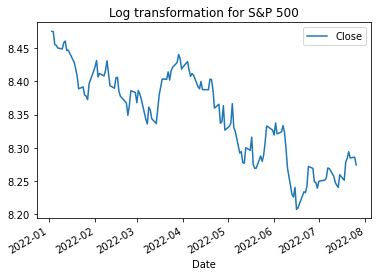

In [6]:
log_prices = np.log(prices)
log_prices.plot(title = 'Log transformation for S&P 500')

Ahora que tenemos la serie transformada, y dado que encontramos en las pruebas de raices unitarias que la serie es no estacionaria, vamos a diferenciarla y evaluar si la serie en diferencias ya es estacionaria para poder seguir con el proceso de identificación

<AxesSubplot:title={'center':'Diff of Log S&P 500'}, xlabel='Date'>

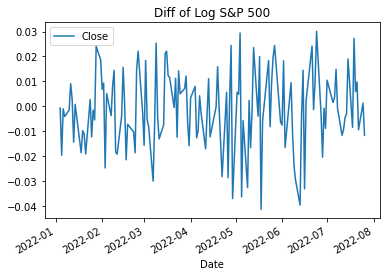

In [12]:
diff_lprices = log_prices.diff().dropna()
diff_lprices.plot(title = 'Diff of Log S&P 500')

In [13]:
DF_test(diff_lprices)

Null hypothesis: Time series is non-stationary 
Statistic: -11.508218729717099 
P-value: 4.323408443664941e-21 
Reject null hypothesis 
:: Time series is stationary


In [14]:
KPSS_test(diff_lprices)

Null hypothesis: Time series is stationary 
Statistic: 0.05449948095750047 
P-value: 0.1 
Failed to reject null hypothesis 
:: Time series is stationary


## 2.Identificación de la serie estacionaria
Ya que tenemos la serie estacionaria (débil) vamos a esoger un modelo adecuado. Para esto utilizaremos las funciones de autocorrelacion y autocorrelacion partial. 

### 2.1 FACE

In [17]:
acf_values = acf(diff_lprices)
acf_values

array([ 1.        ,  0.0153141 , -0.02524742, -0.0342018 ,  0.0441812 ,
       -0.08819139, -0.08969235,  0.05396809, -0.10823265,  0.07830459,
       -0.15275252,  0.09264384, -0.06393023, -0.01599562, -0.06227261,
       -0.08218201,  0.02024582,  0.03509829,  0.01442388, -0.01554188,
        0.13828888, -0.00944533, -0.04961066, -0.05831063, -0.03609272,
       -0.0846057 ,  0.00960228,  0.00832706, -0.03888849, -0.00778869,
       -0.01896205, -0.03333012, -0.00627747,  0.16399208,  0.09424203,
        0.03219447,  0.02053467, -0.08427657, -0.08766037,  0.00112233,
       -0.00859187])

Presenta 1 pico en la FACE

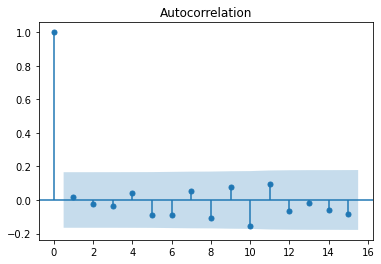

In [36]:
plot_acf(diff_lprices, lags=15);

### 2.2 FACPE

In [37]:
pacf_values = pacf(diff_lprices)
pacf_values

array([ 1.        ,  0.01542427, -0.02585738, -0.03417761,  0.04597684,
       -0.09505256, -0.09035524,  0.05953072, -0.13331066,  0.09692765,
       -0.18058908,  0.09549595, -0.08049024, -0.03627253, -0.06514961,
       -0.11628027, -0.00392786,  0.07164018, -0.08008913,  0.05523784,
        0.06558488,  0.00317639, -0.07178671, -0.0735119 , -0.07084151,
       -0.10903842,  0.03212041, -0.02665209, -0.08361114, -0.03151499,
       -0.05284476, -0.09409814,  0.00487359,  0.18800718,  0.13393886,
        0.04889029,  0.04380822, -0.23315459, -0.16199005,  0.00780478,
       -0.07971695])

Presenta 1 pico en la FACPE

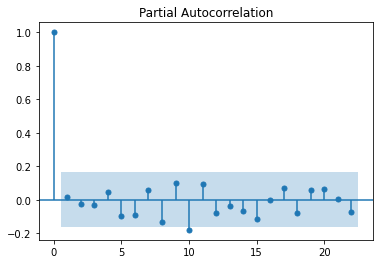

In [41]:
plot_pacf(diff_lprices);

Tenemos en el FACE un comportamiento similar al de un MA(1) y en el  FACPE un comportamiento similar al de un AR(1).

Evaluamos entonces un modelo ARIMA(1,1,1)

In [63]:
arima_model = ARIMA(log_prices, order=(1,1,1))
model = arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76206D+00    |proj g|=  3.61741D+00

At iterate    5    f= -2.76365D+00    |proj g|=  4.53002D-03

At iterate   10    f= -2.76365D+00    |proj g|=  6.70530D-02

At iterate   15    f= -2.76366D+00    |proj g|=  7.15685D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     30      1     0     0   1.723D-05  -2.764D+00
  F =  -2.7636589808195233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


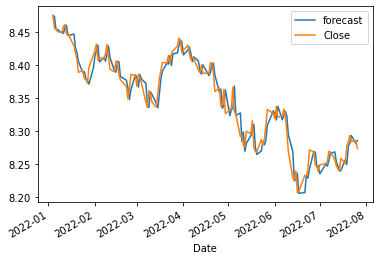

In [64]:
model.plot_predict(dynamic=False)
plt.show()